In [1]:
# Copyright (c) 2018-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import torch
import numpy as np
import matplotlib.pyplot as plt
from common.visualization import render_animation
from IPython.display import HTML

# Human3.6M Visualization

In [2]:
from short_term.dataset_h36m import dataset as h36m

if torch.cuda.is_available():
    h36m.cuda()
h36m.compute_positions() # Forward kinematics on all animations

In [3]:
h36m.subjects()

dict_keys(['S1', 'S11', 'S5', 'S6', 'S7', 'S8', 'S9'])

In [4]:
h36m['S1'].keys()

dict_keys(['directions_1_d0', 'directions_1_d1', 'directions_2_d0', 'directions_2_d1', 'discussion_1_d0', 'discussion_1_d1', 'discussion_2_d0', 'discussion_2_d1', 'eating_1_d0', 'eating_1_d1', 'eating_2_d0', 'eating_2_d1', 'greeting_1_d0', 'greeting_1_d1', 'greeting_2_d0', 'greeting_2_d1', 'phoning_1_d0', 'phoning_1_d1', 'phoning_2_d0', 'phoning_2_d1', 'posing_1_d0', 'posing_1_d1', 'posing_2_d0', 'posing_2_d1', 'purchases_1_d0', 'purchases_1_d1', 'purchases_2_d0', 'purchases_2_d1', 'sitting_1_d0', 'sitting_1_d1', 'sitting_2_d0', 'sitting_2_d1', 'sittingdown_1_d0', 'sittingdown_1_d1', 'sittingdown_2_d0', 'sittingdown_2_d1', 'smoking_1_d0', 'smoking_1_d1', 'smoking_2_d0', 'smoking_2_d1', 'takingphoto_1_d0', 'takingphoto_1_d1', 'takingphoto_2_d0', 'takingphoto_2_d1', 'waiting_1_d0', 'waiting_1_d1', 'waiting_2_d0', 'waiting_2_d1', 'walking_1_d0', 'walking_1_d1', 'walking_2_d0', 'walking_2_d1', 'walkingdog_1_d0', 'walkingdog_1_d1', 'walkingdog_2_d0', 'walkingdog_2_d1', 'walkingtogether_1_d0

The *_d0* or *_d1* suffix represents the version of the sequence after downsampling (even/odd).

In [ ]:
# You can visualize the data as inline HTML5 video
HTML(render_animation(h36m['S1']['walking_1_d0']['positions_world'][:150], h36m.skeleton(), h36m.fps(), output='html'))

In [ ]:
# Alternatively, you can visualize it interactively using the nbagg backend
%matplotlib notebook
anim = render_animation(h36m['S1']['sitting_1_d0']['positions_world'][:150], h36m.skeleton(), h36m.fps(), output='interactive')

# Locomotion generation

In [5]:
from long_term.dataset_locomotion import dataset, long_term_weights_path
from long_term.locomotion_utils import build_extra_features, compute_splines
from long_term.pose_network_long_term import PoseNetworkLongTerm
from common.spline import Spline

if torch.cuda.is_available():
    dataset.cuda()
dataset.compute_positions()
build_extra_features(dataset)
compute_splines(dataset)

In [6]:
dataset.subjects() # This dataset has no subject mapping

dict_keys(['S1'])

In [7]:
# Show 20 random actions
np.random.seed(1)
np.random.choice(list(dataset['S1']), size=20)

array(['jog_sidestep_2_d1', 'jog_sidestep_4_m_d3', 'jog_sidestep_11_d0',
       'jog_sidestep_9_m_d3', 'jog_4_m_d3', 'transitions_5_d1',
       'transitions_8_m_d3', 'transitions_8_d0', 'transitions_4_d1',
       'jog_sidestep_10_d3', 'jog_sidestep_5_m_d1', 'run_4_m_d1',
       'walk_sidestep_2_d2', 'run_3_m_d0', 'jog_sidestep_9_m_d2',
       'walk_5_m_d1', 'jog_sidestep_9_m_d0', 'walk_2_d0',
       'jog_sidestep_5_d2', 'jog_sidestep_10_d0'], dtype='<U20')

Since we downsample the dataset from 120 FPS to 30 FPS, we preserve all four strides (from *_d0* to *_d3*). The samples with the suffix *_m* are mirrored.

In [ ]:
# Let's visualize a sequence from the training set
HTML(render_animation(dataset['S1']['run_4_d0']['positions_world'][:200], dataset.skeleton(), dataset.fps(), output='html'))

In [8]:
from long_term.pace_network import PaceNetwork

# Now, we load the pace network and infer the spline parameters from the trajectory
pace_net = PaceNetwork()
pace_net.load_weights('weights_pace_network.bin')
spline = Spline(dataset['S1']['run_4_d0']['trajectory'][:, [0, 2]], closed=False)

Loading weights from weights_pace_network.bin


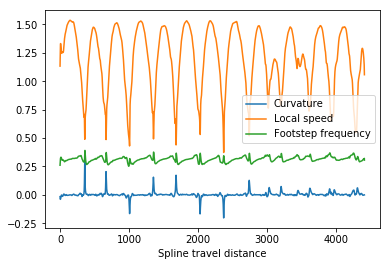

In [9]:
# We want the character to run
%matplotlib inline
spline_run = pace_net.predict(spline, average_speed=1.2)
plt.plot(spline_run.get_track('curvature'))
plt.plot(spline_run.get_track('amplitude'))
plt.plot(spline_run.get_track('frequency'))
plt.legend(['Curvature', 'Local speed', 'Footstep frequency'])
_ = plt.xlabel('Spline travel distance')

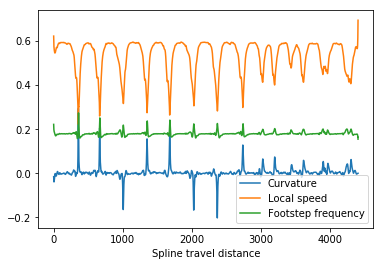

In [10]:
# We want the character to walk
%matplotlib inline
spline_walk = pace_net.predict(spline, average_speed=0.5)
plt.plot(spline_walk.get_track('curvature'))
plt.plot(spline_walk.get_track('amplitude'))
plt.plot(spline_walk.get_track('frequency'))
plt.legend(['Curvature', 'Local speed', 'Footstep frequency'])
_ = plt.xlabel('Spline travel distance')

In [11]:
model = PoseNetworkLongTerm(30, dataset.skeleton())
if torch.cuda.is_available():
    model.cuda()
model.load_weights(long_term_weights_path) # Load pretrained model

# parameters: 9529246
Loading weights from weights_long_term.bin


In [ ]:
# Now let's generate the actual video (for running)
prediction = model.generate_motion(spline_run, dataset['S1']['run_4_d0'])
HTML(render_animation(prediction[100:300], dataset.skeleton(), dataset.fps(), output='html'))

In [ ]:
# (for walking)
prediction = model.generate_motion(spline_walk, dataset['S1']['walk_1_d0'])
HTML(render_animation(prediction[100:300], dataset.skeleton(), dataset.fps(), output='html'))

You can also build your own spline.
For instance, we could define a circular trajectory.

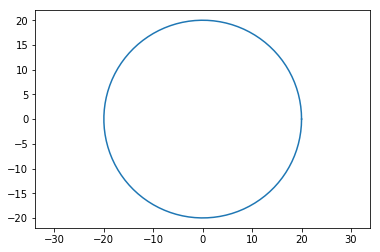

In [12]:
%matplotlib inline
points = np.linspace(0, 2*np.pi, 100)
radius = 20
trajectory = radius * np.stack((np.cos(points), np.sin(points)), axis=1)
plt.plot(*trajectory.T)
_ = plt.axis('equal')

In [13]:
spline_circle = Spline(trajectory, closed=True)
spline_circle = pace_net.predict(spline_circle, average_speed=1.0)
prediction = model.generate_motion(spline_circle, dataset['S1']['jog_1_d0'])

In [ ]:
HTML(render_animation(prediction, dataset.skeleton(), dataset.fps(), output='html'))

In [14]:
# You can also save the animation as an MP4 video (requires ffmpeg)
render_animation(prediction, dataset.skeleton(), dataset.fps(), output='anim.mp4', bitrate=1000)

In [15]:
# ... or a gif (requires imagemagick)
render_animation(prediction, dataset.skeleton(), dataset.fps(), output='anim.gif')

In [23]:
render_animation(dataset['S1']['run_1_d0']['positions_world'][50:200], dataset.skeleton(), dataset.fps(), output='demo.gif')